In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

In [2]:
# Data from 
df = pd.read_csv("COVID-19/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv", index_col=0)
df.index = pd.to_datetime(df.index)
x_data = np.arange(len(df)) + 1
y_data = df['totale_casi']
y_data_deceased = df['deceduti']
last_y = y_data[-1]

In [3]:
df [:2]

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
data,,,,,,,,,,,
2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324
2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623


In [4]:
df[-2:]

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
data,,,,,,,,,,,
2020-03-14 17:00:00,ITA,8372,1518,9890,7860,17750,2795,1966,1441,21157,109170
2020-03-15 17:00:00,ITA,9663,1672,11335,9268,20603,2853,2335,1809,24747,124899


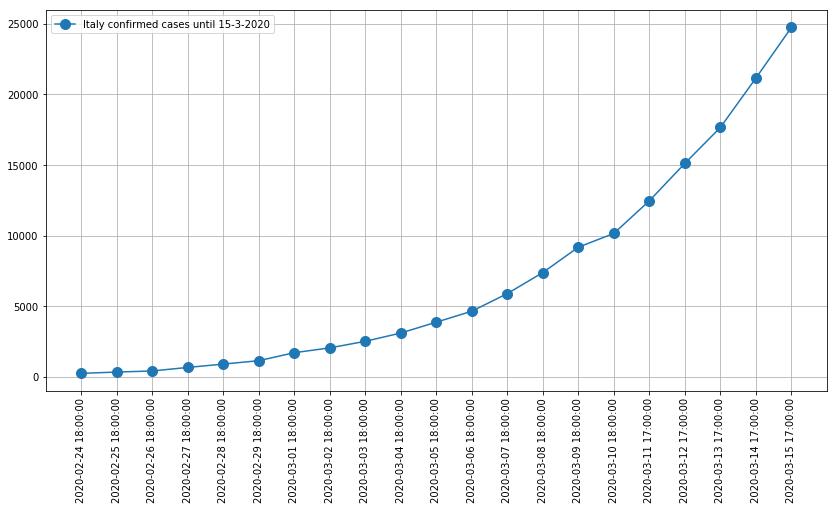

In [6]:
fig1 = plt.figure(figsize=(14, 7))
splt1 = fig1.add_subplot(111)

cases_last_date =  str(df.index[-1].day) + "-" + str(df.index[-1].month) + "-" + str(df.index[-1].year)
splt1.plot(x_data, y_data, '-o', markersize=10, label = f"Italy confirmed cases until {cases_last_date}")

plt.xticks(ticks=x_data, labels=df.index, rotation=90, size = 10)
plt.grid()
plt.legend()

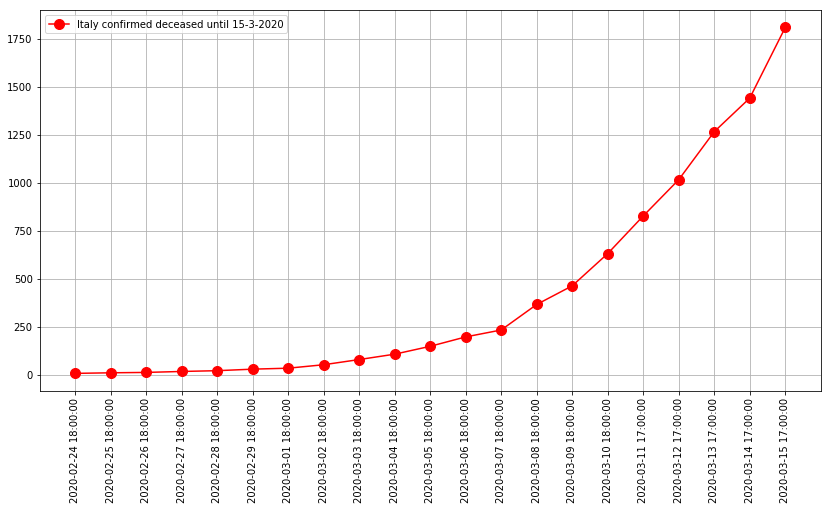

In [7]:
fig2 = plt.figure(figsize=(14, 7))
splt2 = fig2.add_subplot(111)

splt2.plot(x_data, y_data_deceased, '-o', markersize=10, c = 'r', label = f"Italy confirmed deceased until {cases_last_date}")

plt.xticks(ticks=x_data, labels=df.index, rotation=90, size = 10)
plt.grid()
plt.legend()

In [8]:
def logistic_funct(x, params):
    k = params[0]   # steepness 
    l = params[1]   # maximum value
    x0 = params[2]  # sigmoid's midpoint (0 for x-axis simmetry)
    return l / (1 + np.exp(-(x - x0) * k))

def gompertz_funct(x, params):
    a = params[0]   # asymptote 
    k = params[1]   # growth rate
    x0 = params[2]  # inflection midpoint
    return a * (np.exp(-np.exp(-(x - x0) * k)))

In [10]:
def logistic_residuals(params, x, y):
    return logistic_funct(x, params) - y

def gompertz_residuals(params, x, y):
    return gompertz_funct(x, params) - y

In [11]:
initial_params = [0.2, 50000.0, 20.0]

res_lsq = least_squares(logistic_residuals, initial_params, args=(x_data, y_data))
print("Linear loss")
print("steepness =", res_lsq.x[0], "- Maximum value =", res_lsq.x[1], "- Mid point =", res_lsq.x[2])

Linear loss
steepness = 0.2218749174754608 - Maximum value = 73519.64963404184 - Mid point = 24.094036829395794


In [12]:
fit_params_linear = res_lsq.x

([<matplotlib.axis.XTick at 0x1344ffbf4e0>,
 <a list of 3 Text xticklabel objects>)

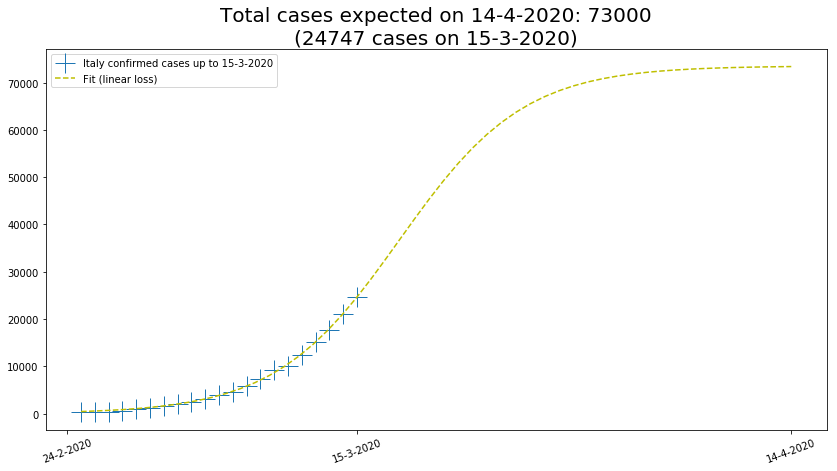

In [13]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)

cases_last_date =  str(df.index[-1].day) + "-" + str(df.index[-1].month) + "-" + str(df.index[-1].year)
ax.plot(x_data, y_data, '+', markersize=20, label = f"Italy confirmed cases up to {cases_last_date}")

x_longer = np.linspace (1, 2.5 * len(x_data))

# Fit on data (linear loss function)
y_fit_linear = logistic_funct(x_longer, fit_params_linear)
ax.plot(x_longer, y_fit_linear, '--', c = 'y', label="Fit (linear loss)")

expected_final = int(np.round(y_fit_linear[-1], decimals=-3))
expected_15_before_final = int(np.round(y_fit_linear[-15], decimals=-3))

final_date = df.index[-1] + 1.5 * (df.index[-1] - df.index[0])
final_date_fmt = str(final_date.day) + "-" + str(final_date.month) + "-" + str(final_date.year) 
plt.title(f"Total cases expected on {final_date_fmt}: {expected_final}\n({last_y} cases on {cases_last_date})", size=20)
plt.legend()

label_dates = [str(df.index[0].day) + "-" + str(df.index[0].month) + "-" + str(df.index[0].year), cases_last_date, final_date_fmt]

plt.xticks(ticks=[0, len(df), 2.5 * len(df)], labels=label_dates, rotation=20, size = 10)